In [93]:
%matplotlib inline
%load_ext rpy2.ipython
import os

GIMME_DIR = "/home/isaac/gimmeSAD/"
SIMOUT_DIR = GIMME_DIR + "1d_sims/"
SIMOUT_DIR_BIG = GIMME_DIR + "sims_H_toobig/1d_sims/"
SNAIL_WORKDIR = "/home/isaac/Continuosity/MESS/empirical_snails/"
OBSERVED_FILE = os.path.join(SNAIL_WORKDIR, "snail.obs")

os.chdir(GIMME_DIR)
import gimmeSAD
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import itertools
import random
import glob
import subprocess

The rpy2.ipython extension is already loaded. To reload it, use:
  %reload_ext rpy2.ipython


In [38]:
def plot_prior_predictive(observed_file, sumstats):
    from sklearn.decomposition import PCA
    import matplotlib.pyplot as plt

    ## Read in observed data
    OBS = np.array([int(x) for x in open(observed_file).readlines()[1].split()])
    print(OBS)
    print(sumstats[0:2])
    #out = np.delete(out, 0, axis=1)

    dat = np.vstack([sumstats, OBS])
    print(dat.shape)
    print(dat[-1])
    pca = PCA(n_components=2)
    X_r = pca.fit(sumstats).transform(sumstats)
    print('explained variance ratio (first two components): %s'
          % str(pca.explained_variance_ratio_))
    plt.figure(dpi=300)
    x, y = zip(*X_r)
    plt.scatter(x, y, color='DodgerBlue', lw=1, alpha=0.5)
    plt.scatter(x[-1], y[-1], c="r")

    ax = plt.gca()
    ax.get_xaxis().set_ticks([])
    ax.get_yaxis().set_ticks([])

In [90]:
def plot_lambda(reftable_file, retained_lambdas):
    from sklearn.decomposition import PCA
    import scipy
    import matplotlib.pyplot as plt
    import pymc3
    import matplotlib
    from matplotlib.font_manager import FontProperties
    matplotlib.font_manager._rebuild()

    out = retained_lambdas
    REF_TABLE = reftable_file

    ## Get lambda prior
    f = open(REF_TABLE).readlines()
    lines = [line.split("\t") for line in f]
    lamb_dat = []
    for line in lines:
        try:
            lamb_dat.append(float(line[3]))
        except:
            pass
    #n, bins, patches = plt.hist(lamb_dat, bins=50, histtype="step", normed=True)

    ## Read in observed data

    #print(out.shape)
    #eqs = np.array(out[1])
    eqs = out
    eqs = eqs[eqs <= 1.0]
    print(np.mean(eqs))
    fig = plt.figure(dpi=300)
    plt.rcParams["font.family"] = "Helvetica"

    ax = fig.gca()
    ax.get_yaxis().set_ticks([])

    ## Histogram of posterior samples
    #_, _, _ = plt.hist(eqs, bins=75, color='grey', lw=1, normed=True)

    ## KDE
    X_plot = np.linspace(0.05, 1, 1000)
    kde = scipy.stats.gaussian_kde(eqs)
    plt.plot(X_plot, kde(X_plot), alpha=0.75, color='black')

    ## HPD
    xs = pymc3.stats.hpd(eqs)
    print(xs)
    plt.axvline(xs[0], color='r', linestyle='--', alpha=0.75)
    plt.axvline(xs[1], color='r', linestyle='--', alpha=0.75)

    font = FontProperties()
    font.set_family('Times New Roman')
    plt.xlabel(u"Λ", fontproperties=font)
    plt.ylabel(u"Density")
    ## Truncate to show all or part of prior
    plt.xlim((0.05, 1))
    _, _, _ = plt.hist(lamb_dat, bins=50, histtype="step", normed=True, color='b', alpha=0.75)
    #plt.savefig("/home/isaac/gimmeSAD/spider-both-equilib-posterior.svg")

In [104]:
def plot_shannon(REF_TABLE, retained_shans):
    from sklearn.decomposition import PCA
    import matplotlib.pyplot as plt
    import pymc3
    import scipy
    import matplotlib
    from matplotlib.font_manager import FontProperties
    matplotlib.font_manager._rebuild()


    ## Get shannon prior
    f = open(REF_TABLE).readlines()
    lines = [line.split("\t") for line in f]

    shan_dat = []
    for line in lines:
        try:
            shan_dat.append(float(line[6]))
        except:
            pass

    shans = retained_shans
    print(np.mean(shans))
    fig = plt.figure(dpi=300)
    plt.rcParams["font.family"] = "Helvetica"

    ax = fig.gca()
    ax.get_yaxis().set_ticks([])
    #_, _, _ = plt.hist(shans, bins=75, color='grey', lw=1, normed=True)

    xmin = 2
    xmax = 5
    ## KDE
    X_plot = np.linspace(xmin, xmax, 1000)
    kde = scipy.stats.gaussian_kde(shans)
    plt.plot(X_plot, kde(X_plot), color='black', alpha=0.75)

    xs = pymc3.stats.hpd(shans)
    print(xs)
    plt.axvline(xs[0], color='r', linestyle='--', alpha=0.75)
    plt.axvline(xs[1], color='r', linestyle='--', alpha=0.75)
    ## Truncate to make it look nicer
    plt.xlim((xmin, xmax))

    #plt.hist(shan_dat, bins=100, histtype="step", normed=True, color='b', alpha=0.75)
    X_plot = np.linspace(xmin, xmax, 1000)
    kde = scipy.stats.gaussian_kde(shan_dat)
    plt.plot(X_plot, kde(X_plot), color='blue', alpha=0.75)

    font = FontProperties()
    font.set_family('Times New Roman')
    plt.xlabel(u"H'", fontproperties=font)
    plt.ylabel(u"Density")

    #plt.savefig("/home/isaac/gimmeSAD/spider-shannon-posterior.svg")

In [94]:
FULL_REF_TABLE = os.path.join(SIMOUT_DIR, "full-priors.txt")
FULL_NORMED_REF_TABLE = os.path.join(SIMOUT_DIR, "full-normed-priors.txt")
FULL_REF_TABLE_BIG = os.path.join(SIMOUT_DIR_BIG, "full-priors.txt")
FULL_NORMED_REF_TABLE_BIG = os.path.join(SIMOUT_DIR_BIG, "full-normed-priors.txt")

force = False
ONEPER = True
REGULARIZE = False
DROPEQUILIBSIMS = False

def construct_full_prior(outfile, ONEPER=False, REGULARIZE=False):
    outfile = open(outfile, "w")
    files = glob.glob(SIMOUT_DIR + "*/sumstats.txt")
    numsims = 0
    outfile.write(open(files[0]).readlines()[0])
    for f in files:
        lines = open(f).readlines()[1:]
        new_lines = []
        for line in lines:
            try:
                ## DO or don't regularlize the histograms
                if REGULARIZE:
                    hist = np.array([int(x) for x in line.split()[7:]])
                    if np.sum(hist):
                        tot = np.sum(hist)
                        hist = hist/float(tot)
                    tmp = line.split()[:7] + map(str,hist)
                    line = "\t".join(tmp) + "\n"

                ## Do or don't drop all the extra sims at equilibrium
                if line.split()[3] == "1" and DROPEQUILIBSIMS:
                    pass
                else:
                    new_lines.append(line)
            except:
                pass
        lines = new_lines
        ## Only choose one step per simulation?
        if lines and ONEPER:
            lines = [random.choice(lines).strip()]

        ## Don't write blanks
        if lines:
            numsims += len(lines)
            lines[-1] = lines[-1].strip()
            outfile.write("".join(lines))
            outfile.write("\n")
    outfile.close()

    print("Processed {} simulations".format(numsims))

if not os.path.exists(FULL_REF_TABLE) or force:
    construct_full_prior(FULL_REF_TABLE, ONEPER=ONEPER)
#if not os.path.exists(FULL_NORMED_REF_TABLE) or force:
#    construct_full_prior(FULL_NORMED_REF_TABLE, ONEPER=ONEPER, REGULARIZE=True)

In [95]:
import sys
UNIF_FULL_REF_TABLE = os.path.join(SIMOUT_DIR, "uniform-full-priors.txt")
UNIF_FULL_NORMED_REF_TABLE = os.path.join(SIMOUT_DIR, "uniform-full-normed-priors.txt")
UNIF_FULL_REF_TABLE_BIG = os.path.join(SIMOUT_DIR_BIG, "uniform-full-priors.txt")
UNIF_FULL_NORMED_REF_TABLE_BIG = os.path.join(SIMOUT_DIR_BIG, "uniform-full-normed-priors.txt")

force = False

def uniform_lambda_prior(intable, outtable):
    dat = pd.read_csv(intable, sep="\t")

    ## Find min bin size
    gt_val = 0.01
    minct = len(dat[dat['%equil'] < gt_val])
    for lt_val in np.arange(0.02, 1.01, .01):
        gt = dat["%equil"] > gt_val
        lt = dat["%equil"] < lt_val
        gt_val = lt_val
        ct = len(dat[lt & gt])
        if ct < minct:
            minct = ct
    print("min bin size {}".format(minct))

    gt_val = 0.01
    outdf = dat[dat['%equil'] < gt_val].sample(n=minct, replace=False)
    outdf = outdf[outdf["K"] > 6000]
    for lt_val in np.arange(0.02, 1.01, .01):
        gt = dat["%equil"] > gt_val
        lt = dat["%equil"] < lt_val
        gt_val = lt_val
        try:
            samps = dat[lt & gt]
            ## Watch this, it'll bite you with the replacement.
            tmpdf = samps.sample(n=minct, replace=False)
        except:
            print(lt_val, len(samps))
        outdf = pd.concat([outdf, tmpdf])
    #outdf
    _, _, _ = plt.hist(outdf["%equil"], bins=100)
    outdf.to_csv(outtable, sep="\t", index=False)
if not os.path.exists(UNIF_FULL_REF_TABLE) or force:
    uniform_lambda_prior(FULL_REF_TABLE, UNIF_FULL_REF_TABLE)
#if not os.path.exists(UNIF_FULL_NORMED_REF_TABLE) or force:
#    uniform_lambda_prior(FULL_NORMED_REF_TABLE, UNIF_FULL_NORMED_REF_TABLE)

In [96]:
%%R -i OBSERVED_FILE -i UNIF_FULL_REF_TABLE_BIG -i UNIF_FULL_REF_TABLE
library(abc)

OBS<- read.table(OBSERVED_FILE, header=TRUE)

## Do or don't regularize the observed pi bins
if(FALSE){
    tot = sum(OBS)
    OBS = data.frame(c(OBS/tot))
    PRIOR <- read.table(UNIF_FULL_NORMED_REF_TABLE, header=TRUE, fill=TRUE)
} else {
    PRIOR <- read.table(UNIF_FULL_REF_TABLE, header=TRUE, fill=TRUE)
}
PRIOR_BIG <- read.table(UNIF_FULL_REF_TABLE_BIG, header=TRUE, fill=TRUE)

## fill adds NA for any incomplete row

print(PRIOR[1,])
print(PRIOR_BIG[1,])
print(OBS)


     K            c    step     X.equil      colrate      extrate  shannon
1 6456 0.0001652509 2920000 0.006660471 0.0001472603 0.0001462329 1.265632
  bin_0 bin_1 bin_2 bin_3 bin_4 bin_5 bin_6 bin_7 bin_8 bin_9
1     0     1     0     0     1     0     0     1     0     2
  bin_0 bin_1 bin_2 bin_3 bin_4 bin_5 bin_6 bin_7 bin_8 bin_9
1    12    10    10     6     3     3     0     1     0     1


## With small K/c

Hit <Return> to see next plot: 
Hit <Return> to see next plot: 
Hit <Return> to see next plot: 
Hit <Return> to see next plot: 
Hit <Return> to see next plot: 


Call: 
abc(target = OBS, param = data.frame(shan = PRIOR[, "shannon"], 
    eq = PRIOR[, "X.equil"], c = PRIOR[, "colrate"], e = PRIOR[, 
        "extrate"], k = PRIOR[, "K"]), sumstat = PRIOR[, 8:17], 
    tol = 1e-04, method = "rejection", hcorr = FALSE)
Data:
 abc.out$unadj.values (103 posterior samples)

                  shan        eq         c         e         k
Min.:           2.8577    0.0266    0.0004    0.0004 5847.0000
2.5% Perc.:     2.8755    0.0409    0.0004    0.0004 6027.0000
Median:         3.2226    0.8719    0.0005    0.0005 9074.0000
Mean:           3.2089    0.7642    0.0006    0.0006 8619.8835
Mode:           3.2576    0.9203    0.0005    0.0005 9642.4925
97.5% Perc.:    3.4667    0.9874    0.0013    0.0009 9869.0000
Max.:           3.5808    0.9981    0.0014    0.0010 9946.0000
                     shan           eq            c            e            k
Min.:        2.857737e+00 2.659411e-02 3.869903e-04 3.816505e-04 5.847000e+03
2.5% Perc.:  2.875460e+00 4.09

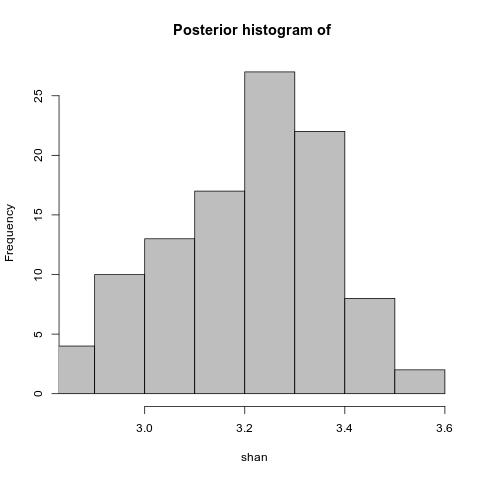

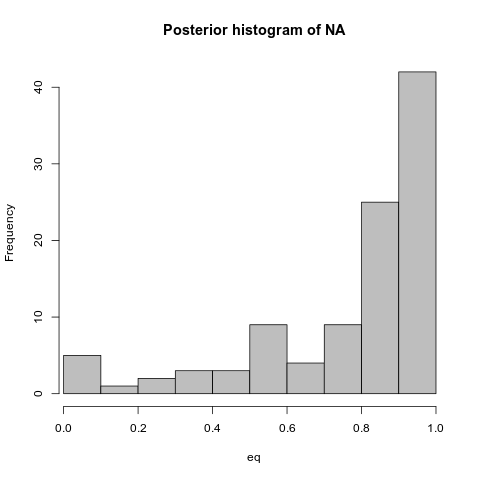

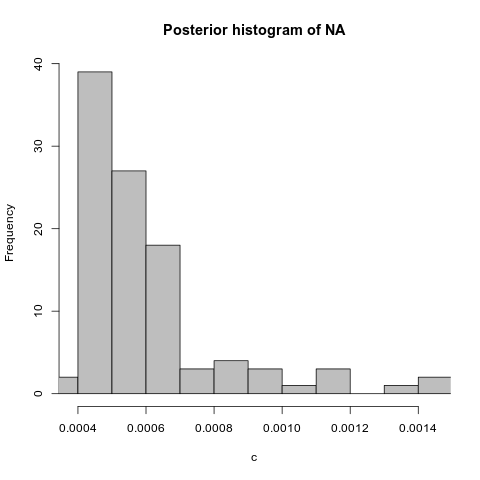

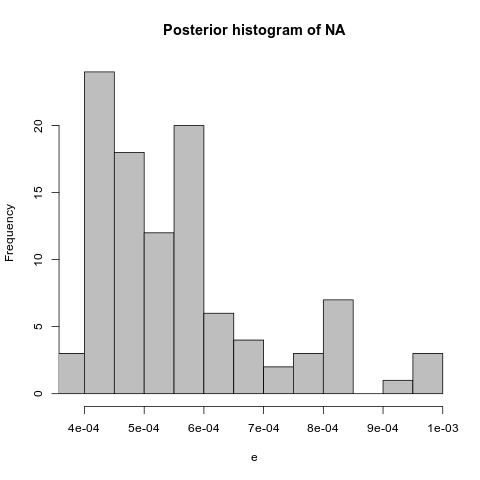

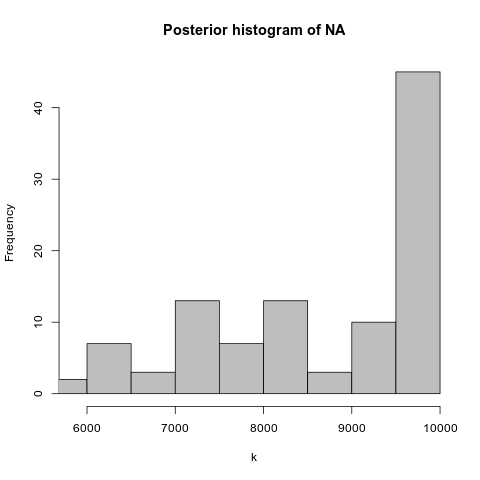

In [114]:
%%R
res_joint_small.abc = abc(target=OBS, param=data.frame(shan=PRIOR[,"shannon"], eq=PRIOR[,"X.equil"],
                                                 c=PRIOR[,"colrate"], e=PRIOR[,"extrate"], k=PRIOR[,"K"]), 
                                                 sumstat=PRIOR[,8:17], hcorr=FALSE, tol=0.0001, method="rejection")
print(summary(res_joint_small.abc))
print(length(res_joint_small.abc$ss))
hist(res_joint_small.abc, cap="", breaks=10)


Error in (function (file = "", n = NULL, text = NULL, prompt = "?", keep.source = getOption("keep.source"),  : 
  <text>:1:42: unexpected numeric constant
1: withVisible({ss=res_joint_small.abc[[12. 11.
                                             ^
392
[12 10 10  6  3  3  0  1  0  1]
[[12. 11.  8.  5.  1.  3.  0.  1.  1.  1.]
 [ 9. 10.  8.  5.  2.  3.  0.  0.  0.  1.]]
(393, 10)
[12. 10. 10.  6.  3.  3.  0.  1.  0.  1.]
explained variance ratio (first two components): [0.28404943 0.24139201]


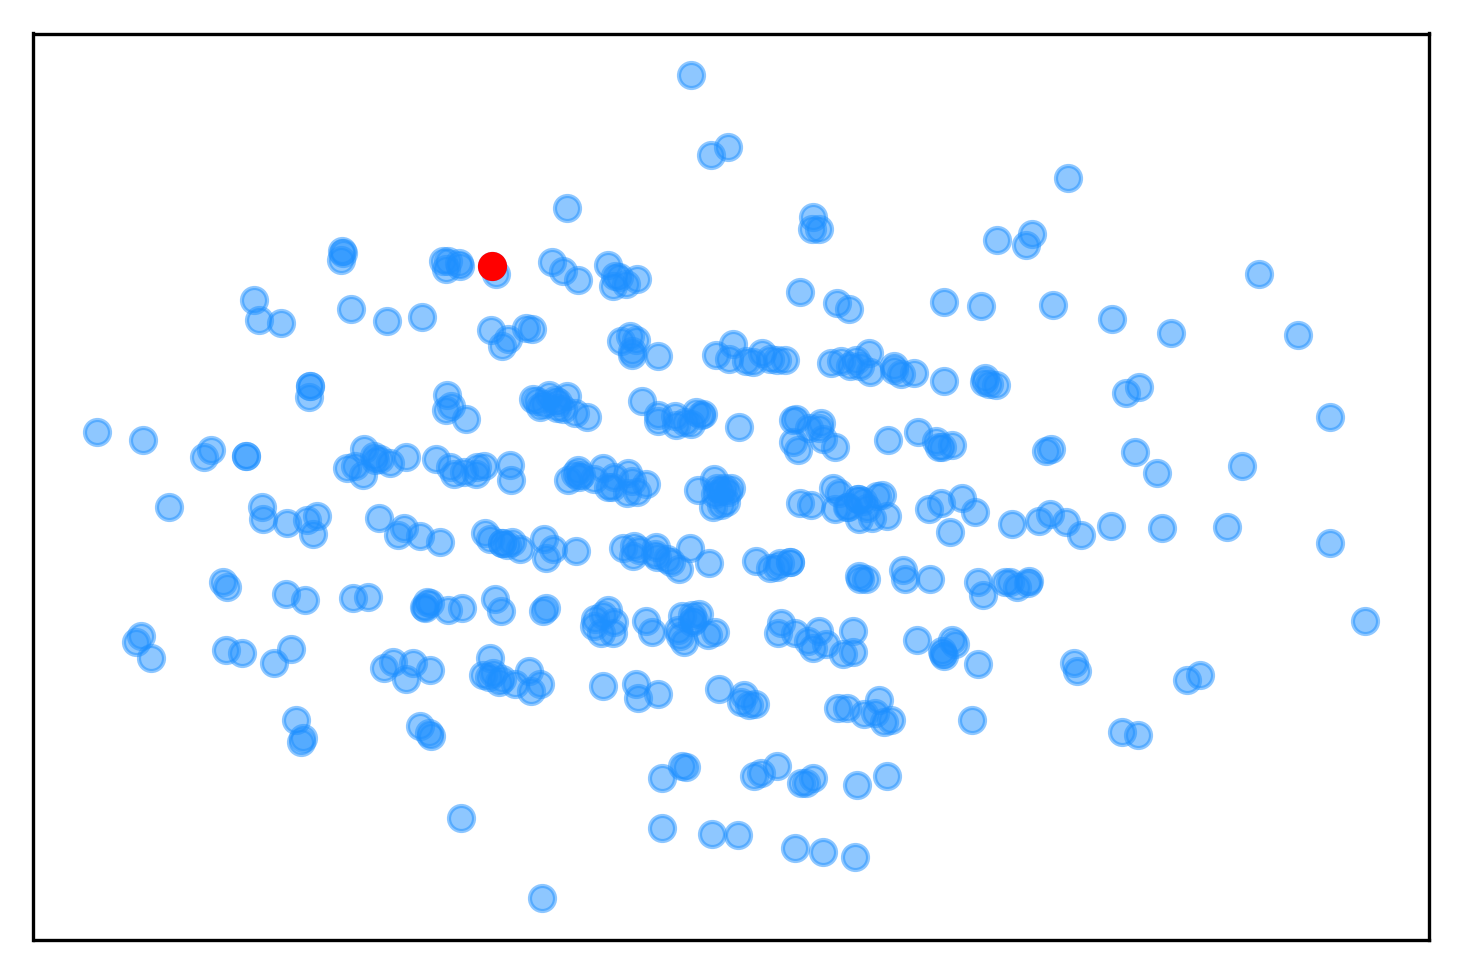

In [115]:
%R -o ss ss=res_joint_small.abc$ss
print(len(ss))
plot_prior_predictive(OBSERVED_FILE, ss)

0.7641555126915447
[0.13573955 0.99812773]


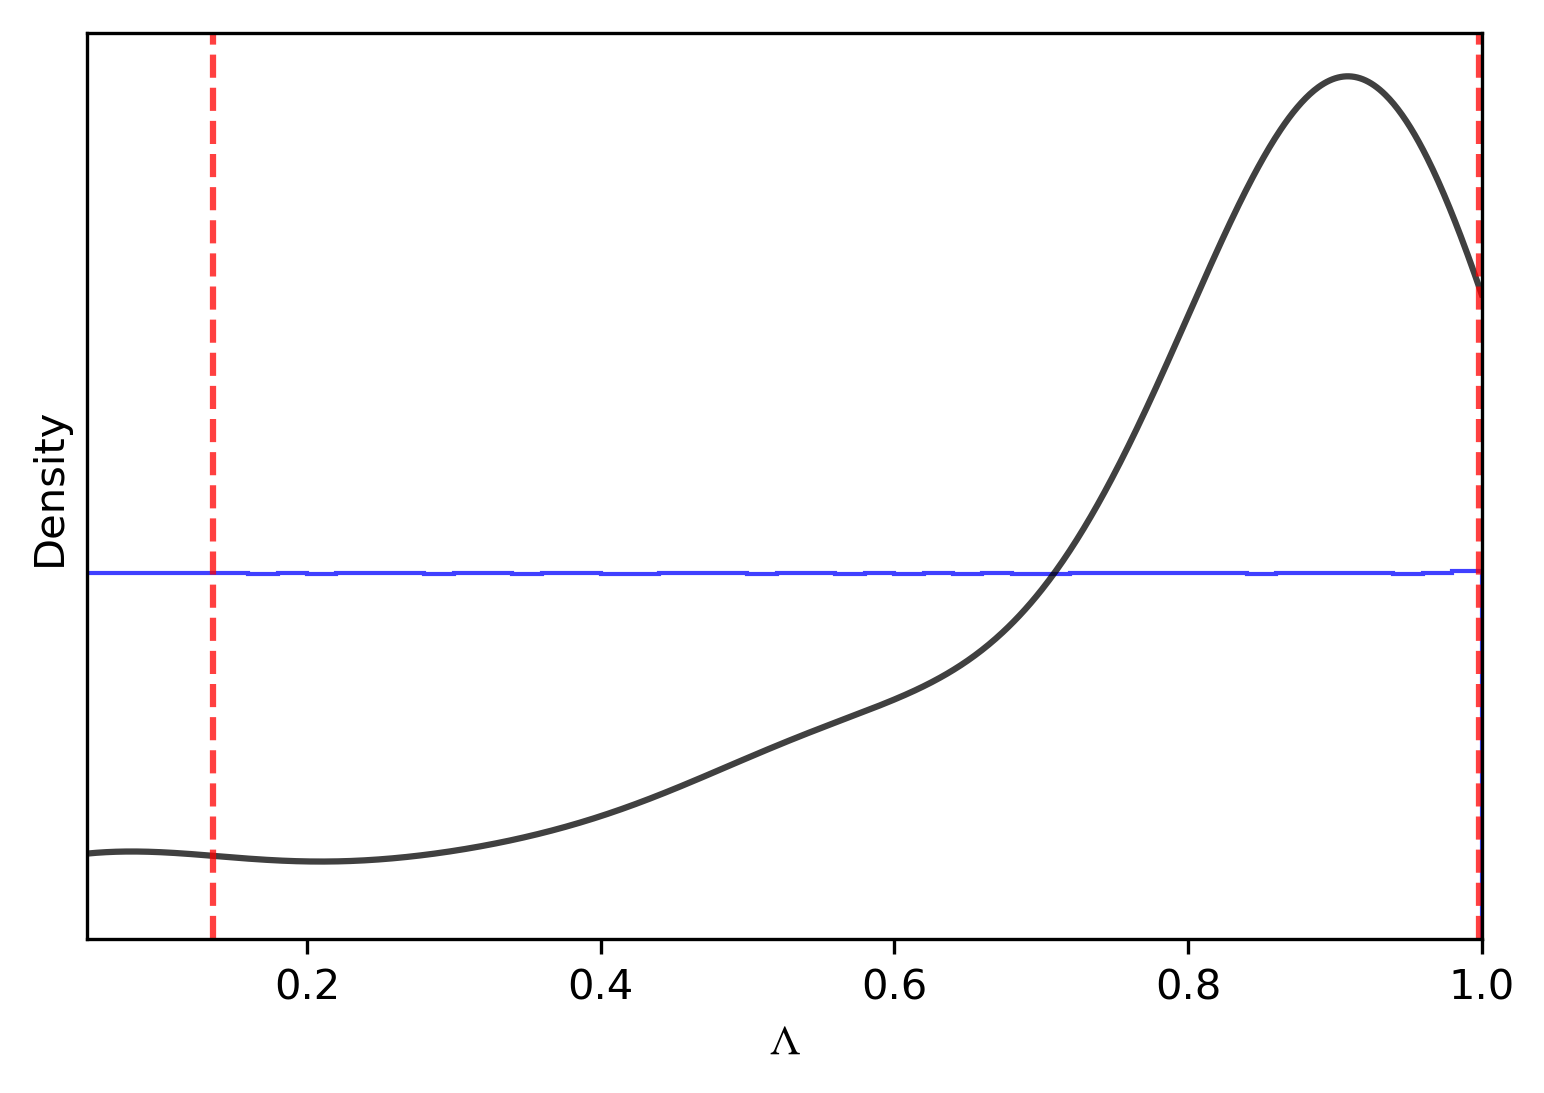

In [111]:
%R -o retained retained=res_joint_small.abc$unadj.values
plot_lambda(UNIF_FULL_REF_TABLE, retained[:,1])

3.178365703917377
[2.85380205 3.48704729]


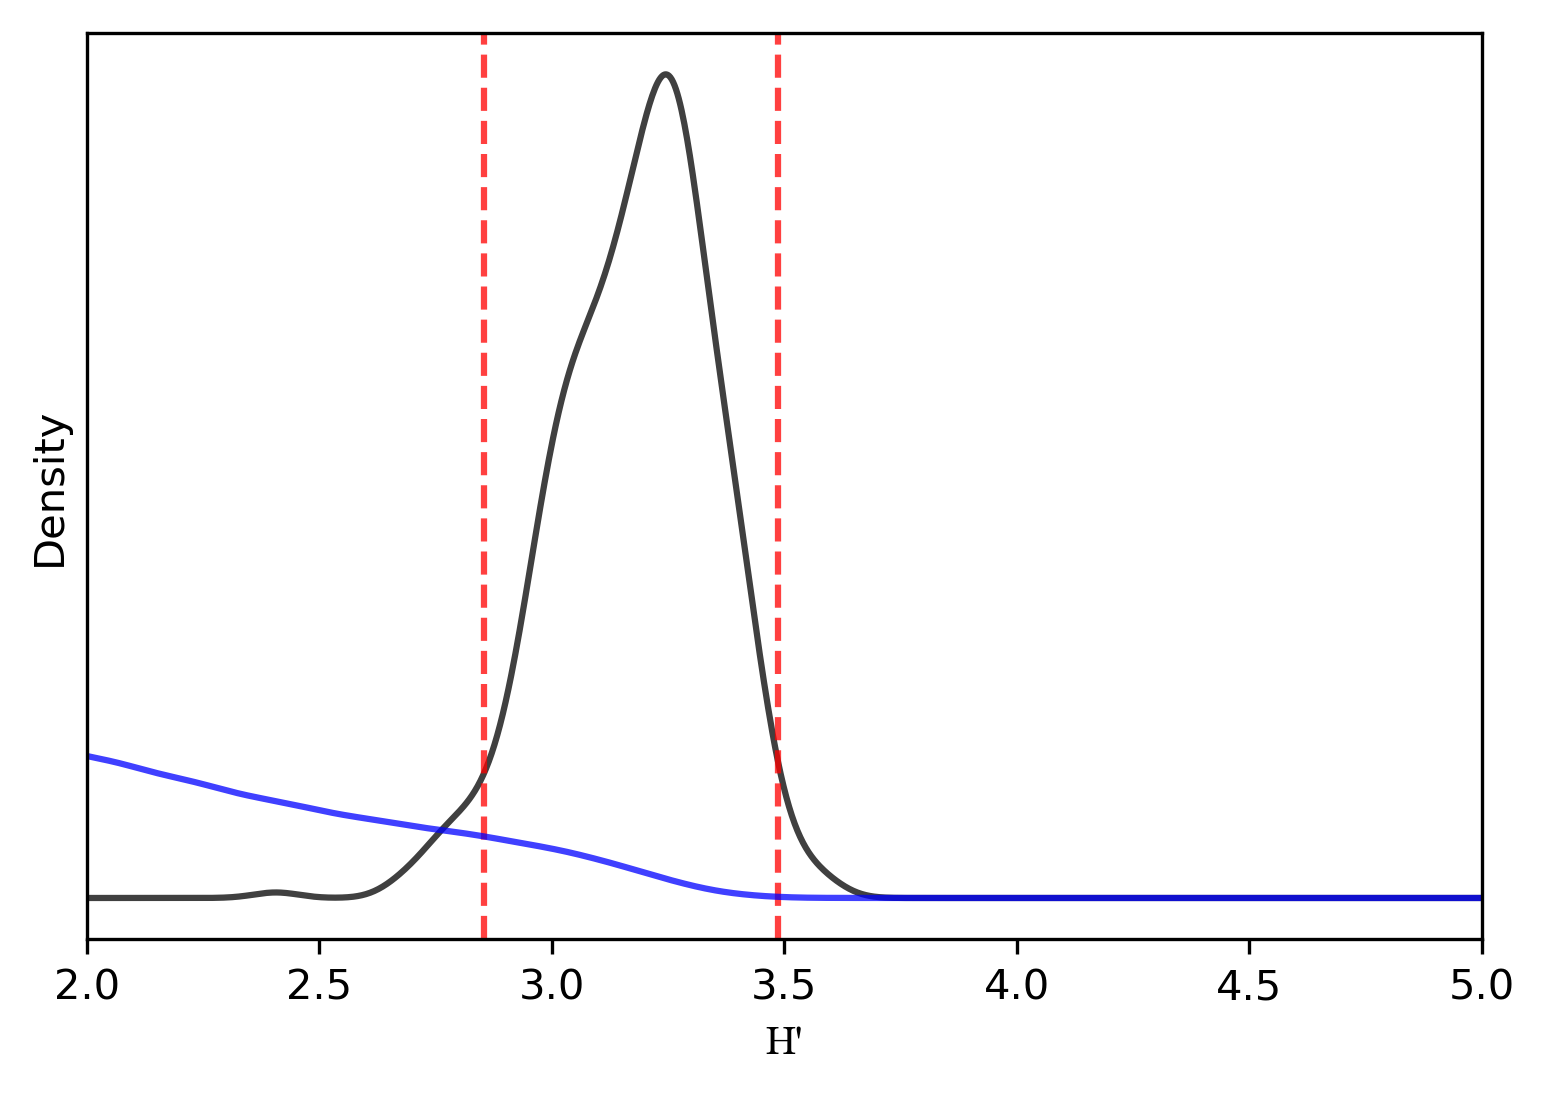

In [106]:
%R -o retained retained=res_joint_small.abc$unadj.values
plot_shannon(UNIF_FULL_REF_TABLE, retained[:,0])

## With large K/c

Hit <Return> to see next plot: 
Hit <Return> to see next plot: 
Hit <Return> to see next plot: 
Hit <Return> to see next plot: 
Hit <Return> to see next plot: 


12345678910
Call: 
abc(target = OBS, param = data.frame(shan = PRIOR_BIG[, "shannon"], 
    eq = PRIOR_BIG[, "X.equil"], c = PRIOR_BIG[, "colrate"], 
    e = PRIOR_BIG[, "extrate"], k = PRIOR_BIG[, "K"]), sumstat = PRIOR_BIG[, 
    8:17], tol = 5e-04, method = "neuralnet", hcorr = FALSE)
Data:
 abc.out$adj.values (196 posterior samples)
Weights:
 abc.out$weights

                             shan         eq          c          e          k
Min.:                      3.1459     0.3242    -0.0007    -0.0002  8415.7108
Weighted 2.5 % Perc.:      3.2618     0.4553     0.0002     0.0002  9962.8961
Weighted Median:           3.4878     0.8868     0.0003     0.0003 13809.0433
Weighted Mean:             3.5014     0.8514     0.0004     0.0003 13579.3553
Weighted Mode:             3.4449     0.9682     0.0003     0.0003 14460.7284
Weighted 97.5 % Perc.:     3.7456     1.1589     0.0007     0.0006 15325.4825
Max.:                      3.8245     1.3640     0.0014     0.0007 17595.0579
          

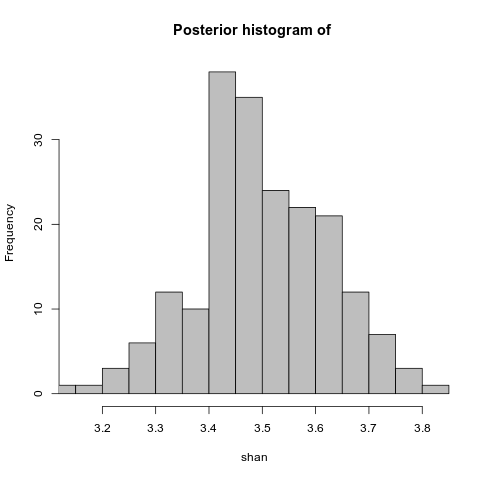

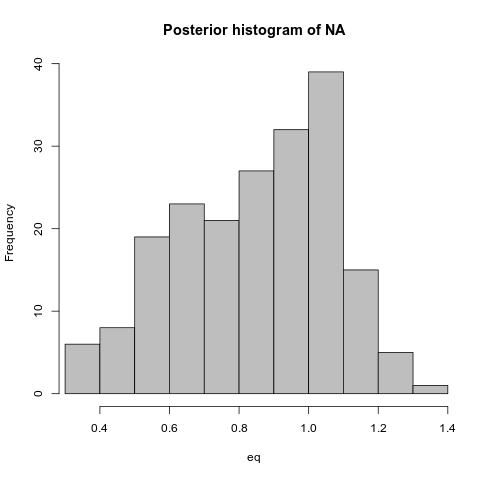

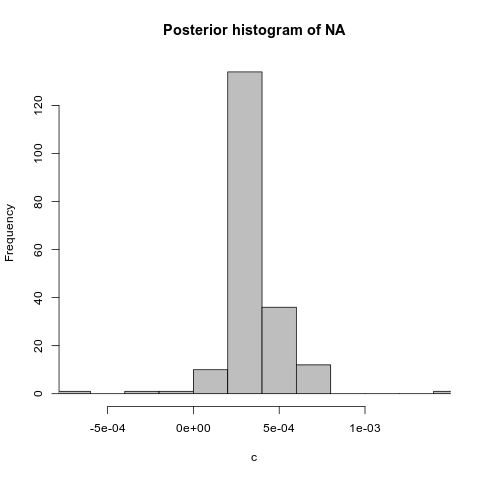

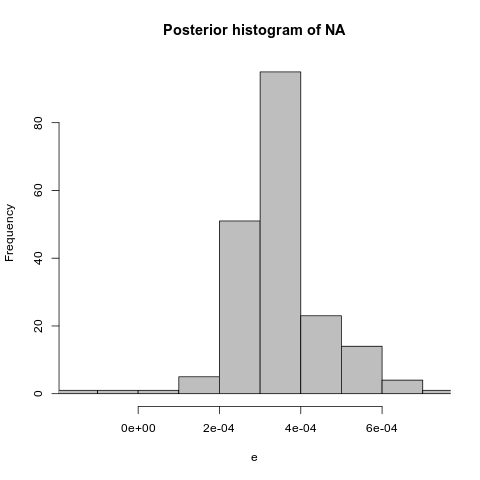

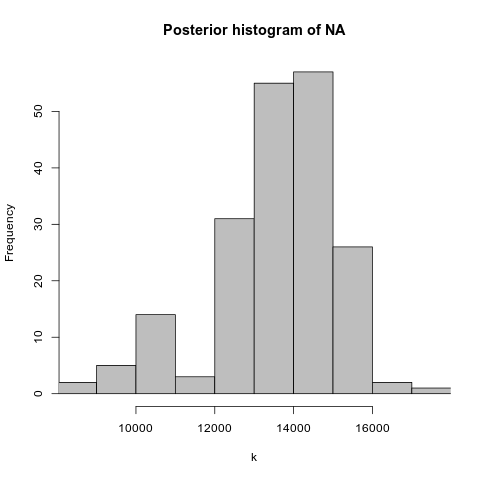

In [116]:
%%R
res_joint_big.abc = abc(target=OBS, param=data.frame(shan=PRIOR_BIG[,"shannon"], eq=PRIOR_BIG[,"X.equil"],
                                                 c=PRIOR_BIG[,"colrate"], e=PRIOR_BIG[,"extrate"], k=PRIOR_BIG[,"K"]), 
                                                 sumstat=PRIOR_BIG[,8:17], hcorr=FALSE, tol=0.0005, method="neuralnet")
print(summary(res_joint_big.abc))
hist(res_joint_big.abc, cap="", breaks=10)


Error in (function (file = "", n = NULL, text = NULL, prompt = "?", keep.source = getOption("keep.source"),  : 
  <text>:1:40: unexpected numeric constant
1: withVisible({ss=res_joint_big.abc[[12. 11.
                                           ^
[12 10 10  6  3  3  0  1  0  1]
[[12. 11.  8.  5.  1.  3.  0.  1.  1.  1.]
 [ 9. 10.  8.  5.  2.  3.  0.  0.  0.  1.]]
(393, 10)
[12. 10. 10.  6.  3.  3.  0.  1.  0.  1.]
explained variance ratio (first two components): [0.28404943 0.24139201]


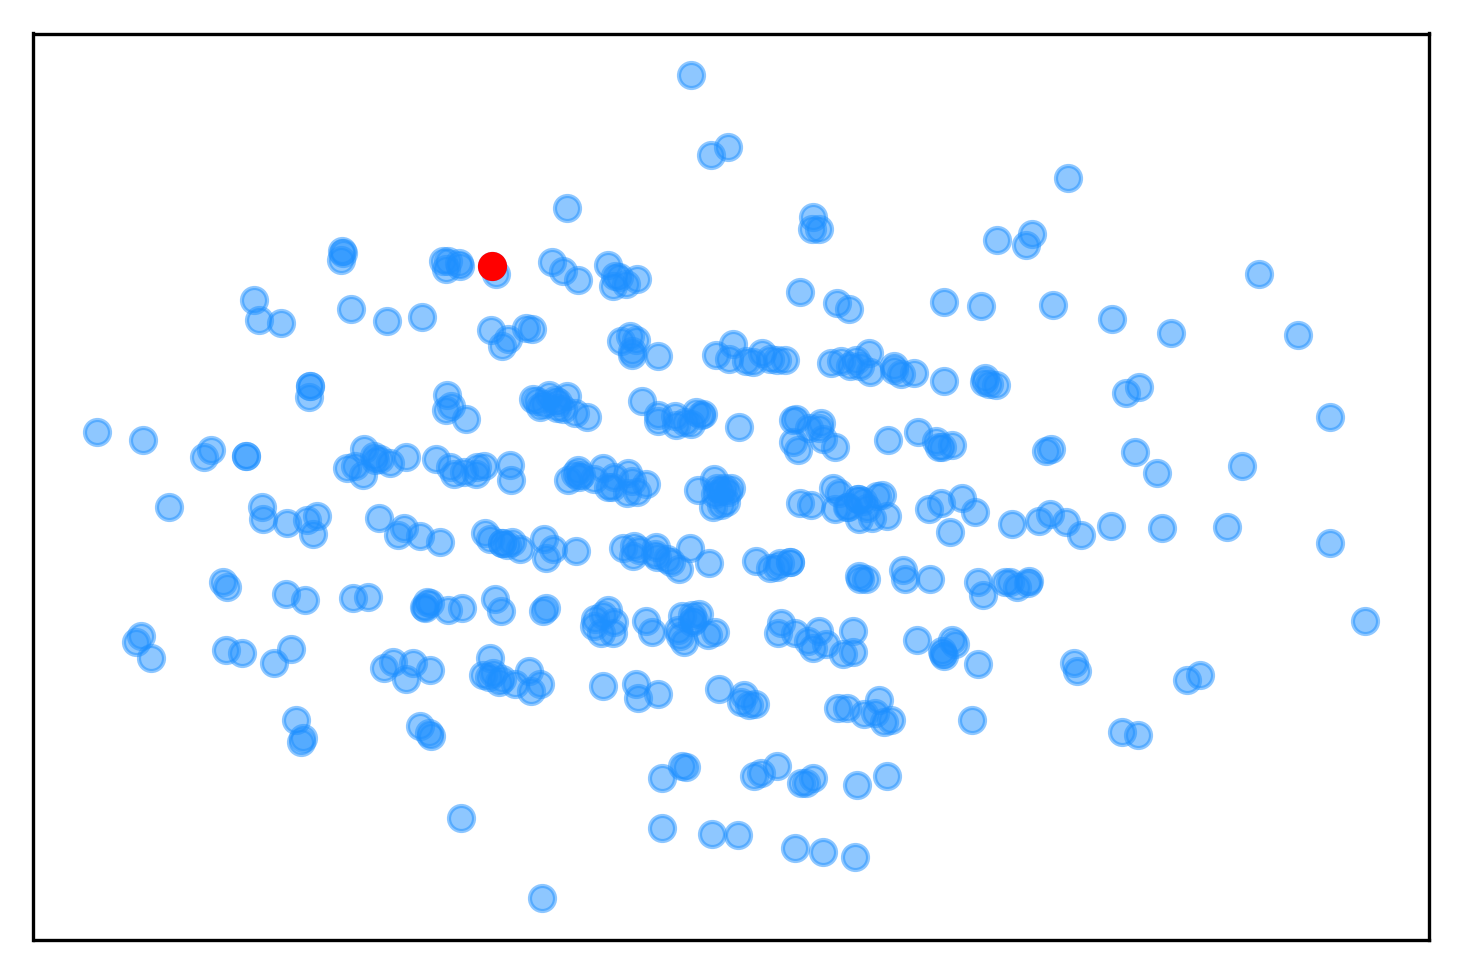

In [39]:
%R -o ss ss=res_joint_big.abc$ss
np.set_printoptions(threshold=np.inf)

plot_prior_predictive(OBSERVED_FILE, ss)

0.668962802975284
[0.12772636 0.99857877]


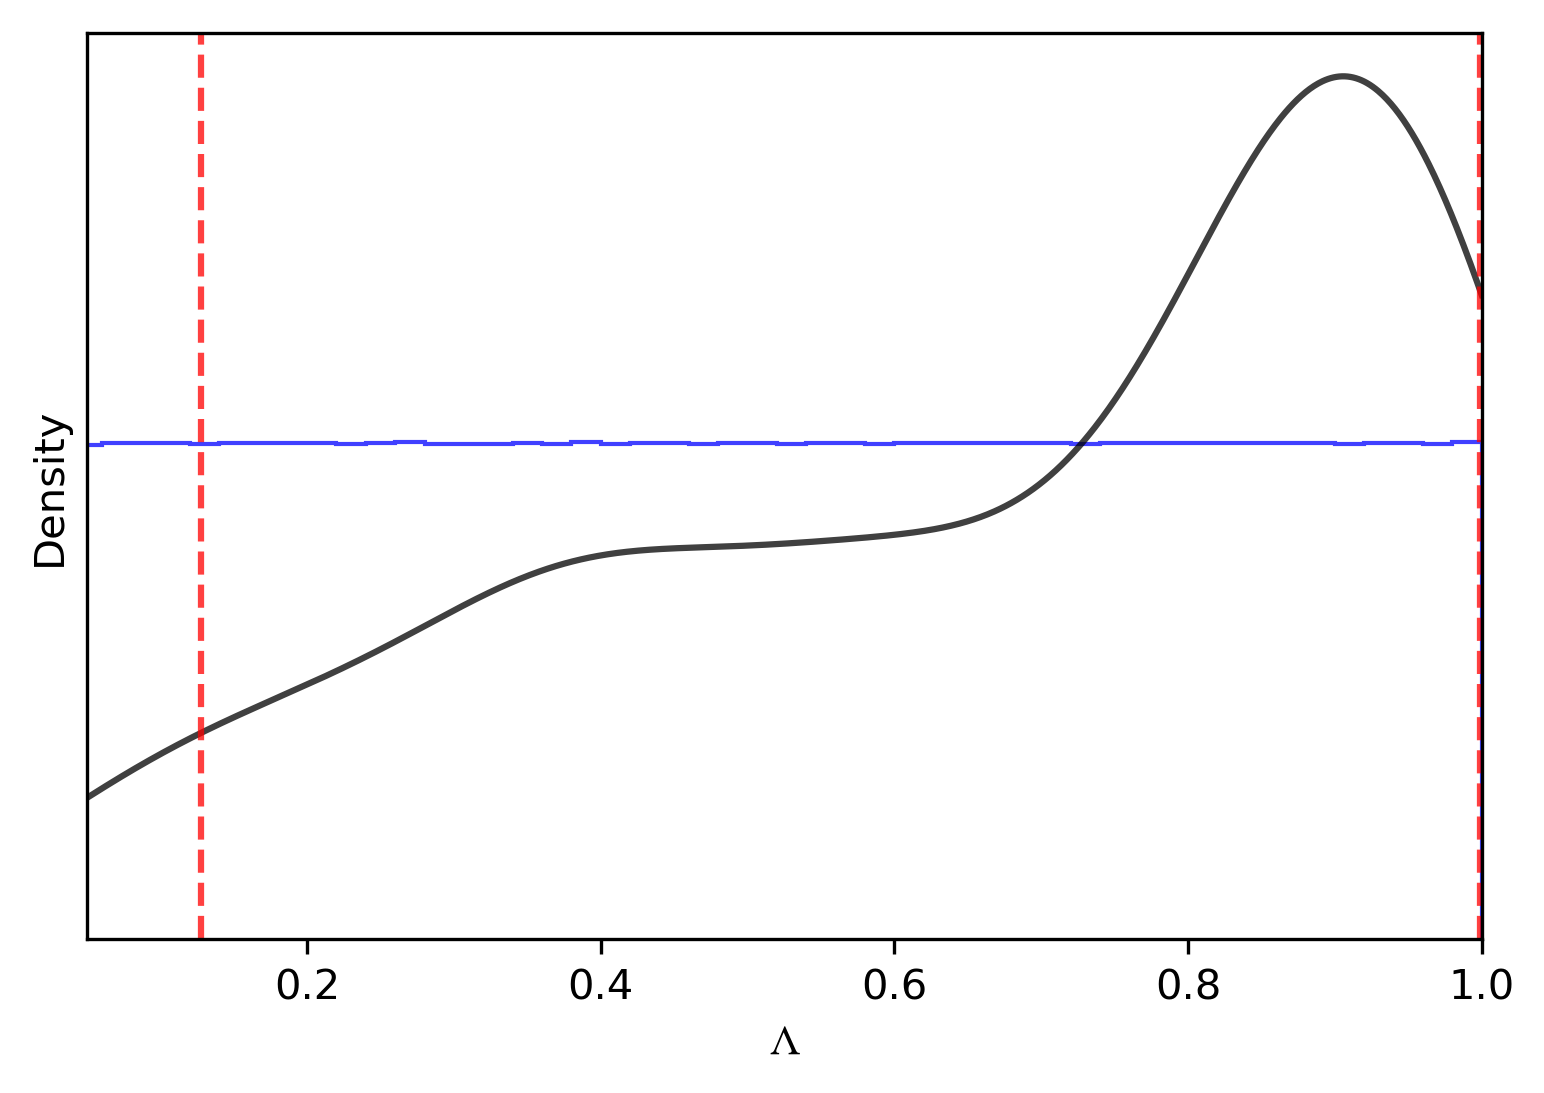

In [117]:
%R -o retained retained=res_joint_big.abc$unadj.values
plot_lambda(UNIF_FULL_REF_TABLE_BIG, retained[:,1])

In [ ]:
%R -o retained retained=res_joint_big.abc$unadj.values
plot_shannon(UNIF_FULL_REF_TABLE_BIG, retained[:,0])

3.462052671766888
[3.22902099 3.72271852]


In [89]:
%R -o wat wat=res_joint_small.abc$unadj.values
print(type(wat))
print(wat[:,1])

<type 'numpy.ndarray'>
[0.01907472 0.02659411 0.02912419 0.028485   0.03583873 0.03290144
 0.04044068 0.04745871 0.04055858 0.04542101 0.04200738 0.06851106
 0.06490535 0.07185365 0.07192411 0.10050643 0.10617106 0.10051677
 0.11059143 0.11617381 0.13573955 0.13468013 0.13952781 0.15208854
 0.15087062 0.17191977 0.19960179 0.20977543 0.20979821 0.21287779
 0.21445987 0.23845176 0.23051291 0.23134929 0.23406627 0.24371473
 0.29600484 0.30868097 0.31047657 0.31666496 0.32738215 0.33456039
 0.3350195  0.33174587 0.33296269 0.34693878 0.36047293 0.36162095
 0.37430337 0.38433479 0.38990522 0.4030112  0.4113952  0.41777308
 0.42202905 0.42857143 0.4357505  0.43591741 0.43775325 0.46952189
 0.4743083  0.47355991 0.47746175 0.48986904 0.48444625 0.48345878
 0.50673212 0.5032835  0.5115007  0.52029651 0.5279157  0.52092411
 0.52288505 0.54908229 0.54453849 0.54676259 0.55411529 0.55273492
 0.55413745 0.56126482 0.5630794  0.56366928 0.56844186 0.56227328
 0.56907299 0.5716103  0.58643645 0.582